IMPORTING THE LIBRARIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from bertopic import BERTopic

# import gensim
# from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [1]:
import os
os.chdir("/Users/mudassirmohammed/AB_CLASSIFICATION")


In [4]:

file = [
    "DATA/Gachibowli_AB.csv",
    "DATA/Jubilee_hills_AB.csv",
    "DATA/Marathahalli_AB.csv",
    "DATA/BTM_Layout_AB.csv",
    "DATA/Mumbai_AB.csv",
    "DATA/Whitefield_AB.csv",
    "DATA/Banjara_hills_AB.csv"
]


In [5]:
#Read all CSV files and concatenate them into a single DataFrame
dfs = []
for file1 in file:
    df = pd.read_csv(file1)
    dfs.append(df)



#Combine all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

In [6]:
pwd


'/Users/mudassirmohammed/AB_CLASSIFICATION'

In [7]:
combined_df.shape

(8123, 7)

In [8]:
combined_df.head()

,Name,Review_Date,Review,Owner_Response,Response_Date,Response,Review_Date.1
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,NaN,NaN
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,NaN,NaN
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,NaN,NaN


In [9]:
#Remove rows where the "Review" column is empty
combined_df.dropna(subset=['Review'], inplace=True)

In [9]:
combined_df.head()

,Name,Review_Date,Review,Owner_Response,Response_Date,Response,Review_Date.1
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,NaN,NaN
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,NaN,NaN
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,NaN,NaN


In [10]:
combined_df['Review'][0]

'Stop eating at this place, I have visited bangalores, nd punes AB but this Hyderabad Gachibowlis one was the worst . First of all no cleanliness, food items were stale nd sorry to say third class crowd over there. Got cockroach in my muffin, here is the proof..'

SAVING THE DATAFRAME TO CSV

In [11]:
combined_df.to_csv("AB_Complaints.csv")

HANDLING MISSING VALUES

In [12]:
combined_df.isnull().sum()

Name               552
Review_Date        552
Review            3918
Owner_Response    4516
Response_Date     5209
Response          4516
Review_Date.1     7430
dtype: int64

In [24]:
combined_df.dropna(subset=['Review'], inplace=True)

In [25]:
combined_df.shape

(4205, 5)

In [26]:
# Fill Response_Date where it is NaT (missing) and Response is not NaT (exists)
combined_df.loc[combined_df['Response_Date'].isna() & combined_df['Response'].notna(), 'Response_Date'] = combined_df['Review_Date']

In [27]:
combined_df.isnull().sum()


Name                0
Review_Date         0
Review              0
Response_Date    2251
Response         2251
dtype: int64

DATA PREPROCESSING

In [28]:
type(combined_df['Review'])
import re
import nltk
from nltk.corpus import stopwords

# Function to preprocess reviews
def preprocess_review(review):
    review = review.lower()  # Convert to lowercase
    review = re.sub(r'[^a-zA-Z\s]', '', review)  # Remove punctuation and numbers
    review = re.sub(r'\s+', ' ', review).strip()  # Remove extra whitespace

    # Tokenization
    tokens = nltk.word_tokenize(review)  # Tokenize after cleaning
    # Remove stopwords and non-alphabetic tokens
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    
    # Join filtered tokens back into a string
    return " ".join(filtered_tokens)

# Assuming you have your DataFrame combined_df
combined_df['Cleaned_Review'] = combined_df['Review'].apply(preprocess_review)

# Display the updated DataFrame
combined_df[['Review', 'Cleaned_Review']].head()


,Review,Cleaned_Review
0,"Stop eating at this place, I have visited bang...",stop eating place visited bangalores nd punes ...
1,Food 2/5\nService 2/5\nAmbience 2/5 …,food service ambience
2,Idiotic varieties for the price they have char...,idiotic varieties price charged varieties boil...
3,"I am posting this live now, this is one of the...",posting live one worst places dont visit pathe...
4,"We are pure vegetarians, I ordered veg biryani...",pure vegetarians ordered veg biryani swiggy go...


In [29]:
def preprocess_name(name):
    name = name.lower()  # Convert to lowercase
    name = re.sub(r'[^a-zA-Z\s]', '', name)  # Remove non-alphabetic characters
    return name.strip()  # Remove leading/trailing whitespace

combined_df['Cleaned_Name'] = combined_df['Name'].apply(preprocess_name)
combined_df[['Name', 'Cleaned_Name']].head()

,Name,Cleaned_Name
0,Pramod Kumar,pramod kumar
1,abhinav deep,abhinav deep
2,Vijay Nammi,vijay nammi
3,surya ajay,surya ajay
4,Sai Hithesh,sai hithesh


In [30]:
combined_df.head()

,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,a year ago,"Dear Guest, Sorry for the inconvenience caused...",food service ambience,abhinav deep
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",a year ago,"Dear Guest, Sorry for the inconvenience caused...",posting live one worst places dont visit pathe...,surya ajay
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh


In [31]:
# Set a random seed for reproducibility
np.random.seed(42)

In [34]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import NMF
# from sklearn.preprocessing import normalize

# # Define category labels as instructed
# category_labels = ['Service Issue', "Food Options", "Food Quality", 
#                    "Atmosphere", "Value for Money", "Hygiene"]

# # Step 1: Install and Import Libraries
# # !pip install sentence-transformers transformers scikit-learn pandas numpy

# import pandas as pd
# from sklearn.cluster import KMeans
# from sentence_transformers import SentenceTransformer



# # Step 3: Preprocess the Review Text
# reviews = combined_df['Cleaned_Review'].fillna('').astype(str)

# # Step 4: Convert Reviews to Semantic Embeddings
# # Load a pre-trained BERT model from the sentence-transformers library
# model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# # Generate embeddings for each review
# embeddings = model.encode(reviews.tolist(), show_progress_bar=True)

# # Step 5: Cluster the Embeddings
# # Define the number of clusters (equal to the number of categories you want)
# num_clusters = 6  # One for each category

# # Using KMeans for clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# labels = kmeans.fit_predict(embeddings)

# # Step 6: Assign Cluster Labels to Reviews
# combined_df['Cluster'] = labels

# # Step 7: Map Clusters to Categories
# # Manually inspect each cluster to identify the best matching category
# # (This is usually a manual step, where you look at some reviews per cluster)
# # Here is a hypothetical mapping based on inspection
# cluster_to_category = {
#     0: 'Service Issue',
#     1: 'Food Options',
#     2: 'Food Quality',
#     3: 'Atmosphere',
#     4: 'Value for Money',
#     5: 'Hygiene'
# }

# # Map the clusters to categories
# combined_df['Category'] = combined_df['Cluster'].map(cluster_to_category)

# # Step 8: View Results
# print(combined_df[['Review', 'Category']].head())

# # Optionally, save the result to a new CSV
# # data.to_csv('reviews_with_categories.csv', index=False)


In [35]:
from transformers import pipeline
import pandas as pd

# Define Labels for Classification
category_labels = ['Service Issue', 'Food Options', 'Food Quality', 
                   'Atmosphere', 'Value for Money', 'Hygiene']
threshold = 0.1  # Adjust this value as needed

# Load Zero-Shot Classification Model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to Classify Each Review with Multi-Label Output
def classify_review(review):
    if pd.isna(review) or review.strip() == "":
        return ["Uncategorized"]
    result = classifier(review, candidate_labels=category_labels, multi_label=True)
    # Select labels with scores above the threshold
    predicted_labels = [label for label, score in zip(result['labels'], result['scores']) if score >= threshold]
    return predicted_labels if predicted_labels else ["Uncategorized"]

# Apply Classification to Each Review
combined_df['Predicted_Category'] = combined_df['Review'].apply(classify_review)

# View Results
print(combined_df[['Review', 'Predicted_Category']].head())
combined_df.to_csv('new_classified_reviews.csv', index=False)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


KeyboardInterrupt: 

In [ ]:
# combined_df.to_csv('new_classified_reviews.csv', index=False)

In [ ]:
# for review in combined_df[combined_df['Category'] == 'Others']['Review'].sample(10):
#     print(review)
#     print()

In [ ]:
# # Step 1: Import Libraries
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import NMF
# from sklearn.preprocessing import normalize



# # Step 3: Define Category Labels
# category_labels = ['Service Issue', "Food options", "Food Quality", 
#                    "Atmosphere", "Value for Money", "Hygiene"]

# # Step 4: Preprocess Reviews
# # Fill NaN values and convert reviews to lowercase
# reviews = combined_df['Review'].fillna('').astype(str).str.lower()

# # Step 5: Vectorize Text using TF-IDF
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
# tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

# # Step 6: Apply NMF to Extract Topics
# num_topics = len(category_labels)
# nmf_model = NMF(n_components=num_topics, random_state=42)
# W = nmf_model.fit_transform(tfidf_matrix)  # Document-topic matrix
# H = nmf_model.components_  # Topic-term matrix

# # Step 7: Normalize the Topic Weights for Multi-Label Assignment
# W_normalized = normalize(W, norm='l1', axis=1)

# # Step 8: Set Threshold and Assign Multiple Labels
# threshold = 0.2  # Adjust this threshold as needed for topic significance


# multi_labels = []
# for weights in W_normalized:
#     # Find topics above the threshold and assign corresponding labels
#     topic_indices = np.where(weights >= threshold)[0]
#     labels = [category_labels[i] for i in topic_indices] if topic_indices.size > 0 else [category_labels[weights.argmax()]]
#     multi_labels.append(labels)

# # Step 9: Add Multi-Labels to DataFrame
# combined_df['Multi_Labels'] = multi_labels

# # Step 10: View Results
# print(combined_df[['Review', 'Multi_Labels']].head())

In [ ]:
# dict1 = combined_df['Multi_Labels'].value_counts()
# dict1

In [1]:
! pipreqs /Users/mudassirmohammed/AB_CLASSIFICATION/app --force

INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /Users/mudassirmohammed/AB_CLASSIFICATION/app/requirements.txt


TOPIC MODELING USING BERTopic

In [ ]:
# # Set a random seed for reproducibility
# np.random.seed(42)



# # Check if the 'Review' column exists
# if 'Cleaned_Review' not in combined_df.columns:
#     raise ValueError("The DataFrame does not contain a 'Cleaned_Review' column.")

# # Load a pre-trained Sentence Transformer model
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# # Create a UMAP instance with desired parameters
# umap_model = UMAP(n_neighbors=40, min_dist=0.0, metric='cosine', random_state=42)

# # Create an HDBSCAN instance with desired parameters
# hdbscan_model = HDBSCAN(min_cluster_size=10)

# # Create a BERTopic model with the UMAP and HDBSCAN instances
# topic_model = BERTopic(
#     embedding_model=sentence_model,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model
# )

# # Fit the model on the processed reviews
# topics, probabilities = topic_model.fit_transform(combined_df['Cleaned_Review'].tolist())

# # Get topic information
# topic_info = topic_model.get_topic_info()

# # Display the number of topics found (including "Topic 0")
# num_topics = topic_info.shape[0]
# print(f'Number of topics: {num_topics}')

# # Display topics with their keywords in a more readable format
# print("\nTopics and their keywords:")
# for i in range(num_topics):
#     try:
#         # Get topic keywords
#         topic_keywords = topic_model.get_topic(i)
#         # Check if topic_keywords is not None or empty
#         if topic_keywords:
#             # Format the output
#             formatted_keywords = ", ".join([word for word, _ in topic_keywords])
#             # Get the number of documents assigned to this topic
#             num_documents = topic_info[topic_info['Topic'] == i]['Count'].values[0]
#             print(f"Topic {i}: {formatted_keywords} (Documents: {num_documents})")
#         else:
#             print(f"Topic {i} has no keywords.")
#     except Exception as e:
#         print(f"Error retrieving keywords for Topic {i}: {e}")


In [ ]:
# category_labels = ['Service Issue', "Technical Issue", "Food Quality", "Atmosphere", "Value for Money", "Others", "Hygiene"]
# topic_labels = {
#     -1:["Others"],
#     0: ["Food Quality"],                  # BBQ references
#     1: ["Food Quality"],                  # Comparison of BBQ
#     2: ["Food Quality"],             # Vegetarian options
#     3: ["Food Quality"],               # General experience
#     4: ["Service Issue","Technical Issue"], # Ambience and service
#     5: ["Technical Issue"],                # Course quality
#     6: ["Atmosphere","Food Quality","Service Issue"],                                # General service
#     7: ["Food Quality"],                  # Buffet experience
#     8: ["Food Quality"],                              # Reservation issues
#     9: ["Atmosphere","Food Quality","Service Issue"],               # General atmosphere
#     10: ["Value for Money","Food Quality"],              # Service and food quality
#     11: ["Atmosphere"],                               # Food taste
#     12: ["Service Issue","Food Quality"],                                     # Branch-specific experience
#     13: ["Food Quality"],                               # Meat taste
#     14: ["Food Quality"],                # Staff friendliness
#     15: ["Atmosphere"],                                     # City comparison
#     16: ["Service Issue"],            # Vegetarian options
#     17: ["Service Issue","Food Quality"],                            # Price quality
#     18: ["Atmosphere"],                               # Taste quality
#     19: ["Food Quality"],                               # Slow service
#     20: ["Atmosphere"],                 # Hygiene issues
#     21: ["Food Quality"],                               # Taste complaints
#     22: ["Food Quality"],                               # Management issues
#     23: ["Food Quality"],                             # Starter options
#     24: ["Value for Money","Service Issue"],              # Negative experiences
#     25: ["Others"],                               # Waiter issues
#     26: ["Food Quality"],            # Cooking issues
#     27: ["Food Quality"],              # Buffet quality
#     28: ["Atmosphere"],                               # Waiter service
#     29: ["Technical Issue"],                               # Worst response
#     30: ["Hygiene"],                               # Specific dish complaints
#     31: ["Hygiene"],                                     # Entertainment issues
#     32: ["Service Issue", "Atmosphere"],              # Staff issues
#     33: ["Service Issue", "Food Quality"],                               # Market experience
#     34: ["Others"],                                    # Stale food
#     35: ["Atmosphere"],                                    # Cleanliness issues
#     36: ["Food Quality"],                               # Serving issues
#     37: ["Others"],                             # Parking issues
#     38: ["Atmosphere","Hygiene"],            # Buffet options
#     39: ["Atmosphere"],                                     # General complaints
#     40: ["Atmosphere","Value for Money"],                               # Dessert issues
#     41: ["Service Issue"],                            # General worth
#     42: ["Service Issue","Food Quality"],                               # Attitude issues
#     43: ["Atmosphere"],                                     # Review issues
#     44: ["Others"],                               # Specific dish complaints
#     45: ["Food Quality"],                             # Menu issues
#     46: ["Food Quality"],                               # Crowding
#     47: ["Atmosphere"],                                  # Buffet quality
#     48: ["Food Quality"],                                     # General drinking issues
#     49: ["Hygiene"],                               # Waiter issues
#     50: ["Food Quality","Hygiene"],                             # Crowding issues
#     51: ["Food Quality","Hygiene"],                             # Booking issues
#     52: ["Technical Issue"],
#     53: ["Food Quality"],
#     54: ["Value for Money"],
#     55: ["Others"]                             # No keywords
# }

# topic_info['Label'] = topic_info['Topic'].map(topic_labels)
# topic_info[['Topic', 'Count', 'Label']]


ANALYZING AND VISUALIZING CATEGORY DISTRIBUTION

MAPPING TOPICS TO CATEGORIES

In [ ]:
# combined_df['Topics'] = topics

# combined_df['Category'] = combined_df['Topics'].map(topic_labels)

CONVERTING REVIEW DATE TO DAYS

In [37]:
def convert_to_days(review_dates):
    # Check if the input is null or empty
    if pd.isnull(review_dates) or review_dates.strip() == '':
        return -1  # Store -1 for null values
    
    # Create a dictionary for conversion
    time_in_days = {
        'year': 365,
        'month': 30,
        'week': 7,
        'day': 1
    }
    
    list1 = review_dates.split()[:2]  # Only take the first two words
    days = 0
    
    
    number = 1 if list1[0] == 'a' else int(list1[0])
    unit = list1[1].rstrip('s')  # Remove the plural 's'
    
    days += number * time_in_days[unit]
    
    return days


In [39]:
combined_df['Review_Days'] = combined_df['Review_Date'].map(convert_to_days)

In [40]:
combined_df.isnull().sum()

Name                 0
Review_Date          0
Review               0
Response_Date     2251
Response          2251
Cleaned_Review       0
Cleaned_Name         0
Review_Days          0
dtype: int64

IDENTIFYING UNIQUE AND REPEAT CUSTOMERS

In [41]:
#Finding Unique Customers
dictionary = combined_df['Cleaned_Name'].value_counts()
dictionary = dictionary.to_dict()

In [42]:
combined_df['Unique_Customer'] = combined_df['Cleaned_Name'].apply(lambda x: 'First_Time' if dictionary[x] == 1 else 'Repeat')

In [43]:
combined_df.isnull().sum()

Name                  0
Review_Date           0
Review                0
Response_Date      2251
Response           2251
Cleaned_Review        0
Cleaned_Name          0
Review_Days           0
Unique_Customer       0
dtype: int64

SEVERITY CLASSIFICATION USING SENTIMENT ANALYSIS

In [44]:
from transformers import pipeline

# Load a sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Analyze sentiment
sentiments = sentiment_pipeline(combined_df['Cleaned_Review'].tolist())
list (sentiments)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'NEGATIVE', 'score': 0.9993200302124023},
 {'label': 'POSITIVE', 'score': 0.998968243598938},
 {'label': 'NEGATIVE', 'score': 0.999792754650116},
 {'label': 'NEGATIVE', 'score': 0.9995315074920654},
 {'label': 'NEGATIVE', 'score': 0.9987488985061646},
 {'label': 'NEGATIVE', 'score': 0.9986369013786316},
 {'label': 'NEGATIVE', 'score': 0.9904683232307434},
 {'label': 'NEGATIVE', 'score': 0.9980587363243103},
 {'label': 'NEGATIVE', 'score': 0.9968034029006958},
 {'label': 'NEGATIVE', 'score': 0.9990240335464478},
 {'label': 'NEGATIVE', 'score': 0.6061022877693176},
 {'label': 'NEGATIVE', 'score': 0.9996324777603149},
 {'label': 'NEGATIVE', 'score': 0.9994240999221802},
 {'label': 'NEGATIVE', 'score': 0.9955106973648071},
 {'label': 'NEGATIVE', 'score': 0.9995400905609131},
 {'label': 'NEGATIVE', 'score': 0.9991546869277954},
 {'label': 'NEGATIVE', 'score': 0.9974332451820374},
 {'label': 'NEGATIVE', 'score': 0.9997349381446838},
 {'label': 'NEGATIVE', 'score': 0.99579381942749

SENTIMENT ANALYSIS USING TEXTBLOB

In [45]:
from textblob import TextBlob

In [46]:
# Function to calculate sentiment using TextBlob
def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity  # Return polarity score

# Apply the function to the 'Review' column
combined_df['Sentiment_Score'] = combined_df['Cleaned_Review'].apply(get_sentiment)

In [47]:
def get_severity(sentiment_score):
	if sentiment_score > 0.1:
		return "Low"
	elif sentiment_score >= -0.1:
		return "Medium"
	else:
		return "High"



# Apply the function to the sentiment scores
combined_df['Severity'] = combined_df['Cleaned_Review'].apply(lambda review: get_severity(TextBlob(review).sentiment.polarity))

# Display the updated DataFrame
combined_df['Severity'].value_counts()

Severity
Low       2119
High      1078
Medium    1008
Name: count, dtype: int64

In [48]:
combined_df.isnull().sum()

Name                  0
Review_Date           0
Review                0
Response_Date      2251
Response           2251
Cleaned_Review        0
Cleaned_Name          0
Review_Days           0
Unique_Customer       0
Sentiment_Score       0
Severity              0
dtype: int64

In [49]:
list1 = list(combined_df['Cleaned_Review'])

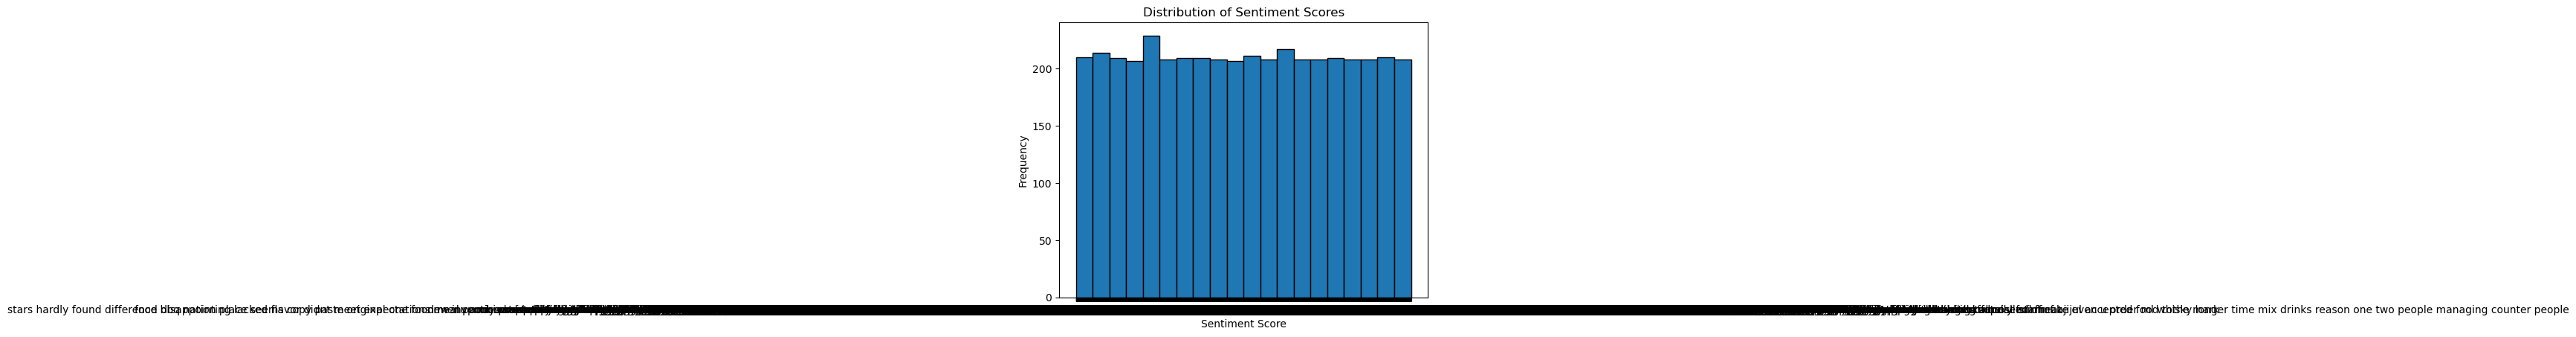

In [50]:
# Assuming 'sentiment_scores' is a list of sentiment scores
plt.hist(list1, bins=20, edgecolor='black')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

IDENTIFYING FREQUENCY OF COMPLAINT TYPE USING TF-IDF AND COSINE SIMILARITY

In [51]:
# creating TfidfVectorizer

vectorizer = TfidfVectorizer()

x = vectorizer.fit_transform(combined_df["Cleaned_Review"])

In [52]:
threshold = 0.7

In [53]:
cosine_sim = cosine_similarity(x, x)

In [54]:
combined_df['Is_Repeated'] = False

# Step 5: Loop through the similarity matrix and mark similar reviews
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i][j] > threshold:
            combined_df.loc[j, 'Is_Repeated'] = True  # Mark the repeated review

In [55]:
combined_df['Is_Repeated'].value_counts()

Is_Repeated
False    4140
True      113
Name: count, dtype: int64

In [56]:
combined_df.isnull().sum()

Name                 48
Review_Date          48
Review               48
Response_Date      2299
Response           2299
Cleaned_Review       48
Cleaned_Name         48
Review_Days          48
Unique_Customer      48
Sentiment_Score      48
Severity             48
Is_Repeated           0
dtype: int64

In [57]:
combined_df['Frequency_Of_Complaint_Type'] = combined_df['Is_Repeated'].apply(lambda x: 'Repeated' if x == True else 'Unique')

In [58]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
dtype: int64

COMPLAINT URGENCY

In [59]:
combined_df['Urgency'] = combined_df['Sentiment_Score'].apply(lambda x: 'Urgent' if x < -0.1 else 'Non-Urgent') 

In [60]:
combined_df['Urgency'].value_counts()

Urgency
Non-Urgent    3175
Urgent        1078
Name: count, dtype: int64

In [61]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
dtype: int64

ACKNOWLEDGEMENT TIME (RESPONSE TIME)

In [62]:
combined_df['Response_Days'] = combined_df['Response_Date'].map(convert_to_days)

In [63]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
dtype: int64

CALCULATING CUSTOMER SATISFACTION BASED ON RESPONSE AND REVIEW DAYS

In [64]:
# Customer Satisfaction Function based on Response_Days and Review_Days
def calculate_satisfaction(response_days, review_days):
    if response_days == -1:  # No response case
        return 'No Response'
    
    days_difference = response_days - review_days  # Calculate difference internally
    
    if days_difference <= 0:
        return 'High Satisfaction'  # Response was immediate or before the review
    elif 1 <= days_difference <= 3:
        return 'Medium Satisfaction'  # Response within a few days
    else:
        return 'Low Satisfaction'  # Delayed response

# Apply the customer satisfaction calculation
combined_df['Customer_Satisfaction'] = combined_df.apply(
    lambda row: calculate_satisfaction(row['Response_Days'], row['Review_Days']),
    axis=1
)

# Display the DataFrame with customer satisfaction
combined_df[['Review_Date', 'Response_Days', 'Review_Days', 'Response_Days', 'Customer_Satisfaction']]

,Review_Date,Response_Days,Review_Days,Response_Days,Customer_Satisfaction
0,6 months ago,-1,180.0,-1,No Response
1,a year ago,365,365.0,365,High Satisfaction
2,a month ago,-1,30.0,-1,No Response
3,a year ago,365,365.0,365,High Satisfaction
4,6 months ago,-1,180.0,-1,No Response
...,...,...,...,...,...
3833,NaN,-1,NaN,-1,No Response
3850,NaN,-1,NaN,-1,No Response
3283,NaN,-1,NaN,-1,No Response
3856,NaN,-1,NaN,-1,No Response


In [65]:
combined_df.head()

,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name,Review_Days,Unique_Customer,Sentiment_Score,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Response_Days,Customer_Satisfaction
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar,180.0,Repeat,-0.350000,High,False,Unique,Urgent,-1,No Response
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,a year ago,"Dear Guest, Sorry for the inconvenience caused...",food service ambience,abhinav deep,365.0,First_Time,0.000000,Medium,False,Unique,Non-Urgent,365,High Satisfaction
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi,30.0,First_Time,-0.388889,High,False,Unique,Urgent,-1,No Response
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",a year ago,"Dear Guest, Sorry for the inconvenience caused...",posting live one worst places dont visit pathe...,surya ajay,365.0,First_Time,-0.772727,High,False,Unique,Urgent,365,High Satisfaction
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,180.0,First_Time,0.214286,Low,False,Unique,Non-Urgent,-1,No Response


In [66]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
Customer_Satisfaction             0
dtype: int64

In [67]:
# Display rows with any null values in the DataFrame
null_rows = combined_df[combined_df.isnull().any(axis=1)]

# Show the DataFrame with null rows
null_rows


,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name,Review_Days,Unique_Customer,Sentiment_Score,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Response_Days,Customer_Satisfaction
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar,180.0,Repeat,-0.350000,High,False,Unique,Urgent,-1,No Response
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi,30.0,First_Time,-0.388889,High,False,Unique,Urgent,-1,No Response
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,180.0,First_Time,0.214286,Low,False,Unique,Non-Urgent,-1,No Response
5,armaan akhter,a week ago,waste management they gave us time 3.30 PM @Ga...,NaN,NaN,waste management gave us time pm gachibowli br...,armaan akhter,7.0,First_Time,-0.375000,High,False,Unique,Urgent,-1,No Response
8,Keshav Akkineni,3 months ago,"The food was not good at all. The plates, spoo...",NaN,NaN,food good plates spoons bowls cleaned properly...,keshav akkineni,90.0,First_Time,-0.083333,Medium,False,Unique,Non-Urgent,-1,No Response
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response


DELETING NULL ROWS

In [68]:
# Set the threshold for non-null values
# For example, keep rows with at least 5 non-null values
threshold = 6

# Drop rows with less than the specified threshold of non-null values
combined_df = combined_df.dropna(thresh=threshold)

# Check the number of null values after deletion
print(combined_df.isnull().sum())


Name                              0
Review_Date                       0
Review                            0
Response_Date                  2251
Response                       2251
Cleaned_Review                    0
Cleaned_Name                      0
Review_Days                       0
Unique_Customer                   0
Sentiment_Score                   0
Severity                          0
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
Customer_Satisfaction             0
dtype: int64


In [69]:
combined_df.shape

(4205, 16)

In [70]:

# new_df = combined_df[['Review','Cleaned_Review', 'Cleaned_Name', 'Category', 
#                       'Severity', 'Is_Repeated', 'Frequency_Of_Complaint_Type', 
#                       'Urgency', 'Customer_Satisfaction', 'Review_Days', 
#                       'Response_Days']].copy()

# # Optionally, reset the index of the new DataFrame
# new_df.reset_index(drop=True, inplace=True)

# # Display the new DataFrame
# new_df.head()


In [71]:
# category_dummies = combined_df['Category'].str.get_dummies(sep=', ')
# category_dummies.head()

In [72]:
# def add_category_features(df, categories):
#     """
#     Adds binary columns for each specified category in the DataFrame.
    
#     Parameters:
#     - df (pd.DataFrame): The original DataFrame with a 'Category' column containing lists of categories.
#     - categories (list of str): List of categories to be added as new columns.
    
#     Returns:
#     - pd.DataFrame: Updated DataFrame with new binary category columns.
#     """
#     # Loop through each category and create a new column in the DataFrame
#     for category in categories:
#         # Check if each category is present in the list of categories for each review
#         df[category] = df['Category'].apply(lambda x: 1 if category in x else 0)
    
#     return df



# # List of categories to be checked and added as columns
# categories_to_add = ['Service Issue', "Food Options", "Food Quality", "Atmosphere", "Value for Money", "Others", "Hygiene"]
# # category_labels = ['Service Issue', "Technical Issue", "Food Quality", "Atmosphere", "Value for Money", "Others", "Hygiene"]
# # Apply the function to add the new features
# new_df = add_category_features(new_df, categories_to_add)

# # Display the updated DataFrame
# new_df


In [73]:
# vectorizer = TfidfVectorizer()
# x = vectorizer.fit_transform(df["Cleaned_Review"])
# threshold = 0.7
# cosine_complaint = cosine_similarity(vectorizer.transform([complaint]), x)
# if cosine_similarity > threshold: 
#     print("Frequency of Complaint: Recurring")
# else:
#     print("Frequency of Complaint: First-time")